In [9]:
"""
Non-severe (trivial, minor)
Severe (major, critical, blocker)

Source code adapted from: 
    https://github.com/karthikmswamy/Keras_In_TensorFlow
    https://github.com/cmasch/cnn-text-classification/blob/master/Evaluation.ipynb
"""
from __future__ import print_function

import os, pickle, string
import sys
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
#import keras.backend as K

from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model


BASE_DIR = '/home/jacson/work/bug_report_prediction/data/Binary'
GLOVE_DIR = '/home/jacson/work/glove/glove.6B/'
TEXT_DATA_DIR = BASE_DIR + '/Platform/'

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jacson/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Parameter

In [10]:
# EMBEDDING
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 1000

# MODEL

# LEARNING
RUNS           = 5
VALIDATION_SPLIT = 0.2

In [11]:
def clean_doc(doc):
    """
    Cleaning a document by several methods:
        - Lowercase
        - Removing whitespaces
        - Removing numbers
        - Removing stopwords
        - Removing punctuations
        - Stemming
        - Removing short words
    """
    stop_words = set(stopwords.words('english'))
    
    # Lowercase
    doc = doc.lower()
    # Remove numbers
    doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove Stopwords
    tokens = [w for w in tokens if not w in stop_words]
    # Remove punctuation
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # Stemming Algorithms
    #porter_stemmer = PorterStemmer()
    #tokens = porter_stemmer.stem(tokens)
    # Tokens with less then two characters will be ignored
    #tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

In [12]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
         self.val_f1macros = []
         self.val_f1micros = []
         self.val_recalls = []
         self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
         val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
         val_targ = self.validation_data[1]
         _val_f1macro = f1_score(np.argmax(val_targ, axis=1), np.argmax(val_predict, axis=1), average='macro')
         _val_f1micro = f1_score(np.argmax(val_targ, axis=1), np.argmax(val_predict, axis=1), average='micro')
         _val_recall = recall_score(np.argmax(val_targ, axis=1), np.argmax(val_predict, axis=1))
         _val_precision = precision_score(np.argmax(val_targ, axis=1), np.argmax(val_predict, axis=1))
         self.val_f1macros.append(_val_f1macro)
         self.val_f1micros.append(_val_f1micro)
         self.val_recalls.append(_val_recall)
         self.val_precisions.append(_val_precision)
         print ('— val_f1macro: %f — val_f1micro: %f — val_precision: %f — val_recall %f' %(_val_f1macro, _val_f1micro, _val_precision, _val_recall))
         return

In [13]:
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [14]:
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    #print('path:'+path, 'name:'+name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        #print('label_id:', label_id)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            #plabels_indexlabels_indexrint('fname:'+fname)
            if fname.isdigit() == False:
                fpath = os.path.join(path, fname)
                #print('fpath:'+fpath)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                t = clean_doc(t)
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))
print(labels_index)
print(labels)
print(texts)



Processing text dataset
Found 5884 texts.
{'non-severe': 0, 'severe': 1}
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

#print(sequences)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

Found 6207 unique tokens.
Shape of data tensor: (5884, 1000)
Shape of label tensor: (5884, 2)
Preparing embedding matrix.


In [16]:
#print(MAX_NB_WORDS, len(word_index)+1)
num_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Training

In [17]:
histories = []
metricsc = Metrics()

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))

    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(35)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
                  

    history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=2, #10
              validation_data=(x_val, y_val),
              callbacks=[metricsc, ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                       verbose=1, save_best_only=True, mode='min'),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                      ]
             )

    print()
    histories.append(history.history)

Training model.
Running iteration 1/5
Train on 4708 samples, validate on 1176 samples
Epoch 1/2
4708/4708 [==============================] - 21s 5ms/step - loss: 0.5917 - acc: 0.6947 - val_loss: 0.5559 - val_acc: 0.7032
— val_f1macro: 0.509564 — val_f1micro: 0.703231 — val_precision: 0.711818 — val_recall 0.960736

Epoch 00001: val_loss improved from inf to 0.55593, saving model to model-1.h5
Epoch 2/2
4708/4708 [==============================] - 24s 5ms/step - loss: 0.5114 - acc: 0.7455 - val_loss: 0.5819 - val_acc: 0.7279
— val_f1macro: 0.551109 — val_f1micro: 0.727891 — val_precision: 0.725205 — val_recall 0.977914

Epoch 00002: val_loss did not improve from 0.55593

Running iteration 2/5
Train on 4708 samples, validate on 1176 samples
Epoch 1/2
4708/4708 [==============================] - 24s 5ms/step - loss: 0.5903 - acc: 0.6880 - val_loss: 0.5765 - val_acc: 0.6956
— val_f1macro: 0.430895 — val_f1micro: 0.695578 — val_precision: 0.696475 — val_recall 0.993865

Epoch 00001: val_los

/home/jacson/anaconda3/envs/tensorflowpy36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


— val_f1macro: 0.409342 — val_f1micro: 0.693027 — val_precision: 0.693027 — val_recall 1.000000

Epoch 00001: val_loss improved from inf to 0.55601, saving model to model-4.h5
Epoch 2/2
4708/4708 [==============================] - 24s 5ms/step - loss: 0.5116 - acc: 0.7419 - val_loss: 0.5421 - val_acc: 0.7236
— val_f1macro: 0.668118 — val_f1micro: 0.723639 — val_precision: 0.790974 — val_recall 0.817178

Epoch 00002: val_loss improved from 0.55601 to 0.54205, saving model to model-4.h5

Running iteration 5/5
Train on 4708 samples, validate on 1176 samples
Epoch 1/2
4708/4708 [==============================] - 25s 5ms/step - loss: 0.5868 - acc: 0.6898 - val_loss: 0.5593 - val_acc: 0.6998
— val_f1macro: 0.449525 — val_f1micro: 0.699830 — val_precision: 0.700173 — val_recall 0.991411

Epoch 00001: val_loss improved from inf to 0.55926, saving model to model-5.h5
Epoch 2/2
4708/4708 [==============================] - 24s 5ms/step - loss: 0.5182 - acc: 0.7356 - val_loss: 0.5564 - val_acc: 0.

In [18]:
with open('history.pkl', 'wb') as f:
    pickle.dump(histories, f)

Evaluation

In [19]:
histories = pickle.load(open('history.pkl', 'rb'))

In [24]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc / %0.4f val_f1macro / %0.4f val_f1micro / %0.4f val_precision / %0.4f val_recall' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc'),
                                                get_avg(histories, 'val_f1macros'),
                                                get_avg(histories, 'val_f1micros'),
                                                get_avg(histories, 'val_precisions'),
                                                get_avg(histories, 'val_recalls')))

Training: 	0.5286 loss / 0.7329 acc


KeyError: 'val_f1macros'

In [39]:

def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    #fig.savefig(title+'.png')
    plt.show()

In [35]:

def plot_f1(title, histories, key_microf1, key_macrof1):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model microf1 (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_microf1])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('microf1')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model macrof1 (%s)' % title)
    for model in histories:
        ax2.plot(model[key_macrof1])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('macrof1')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    #fig.savefig(title+'.png')
    plt.show()

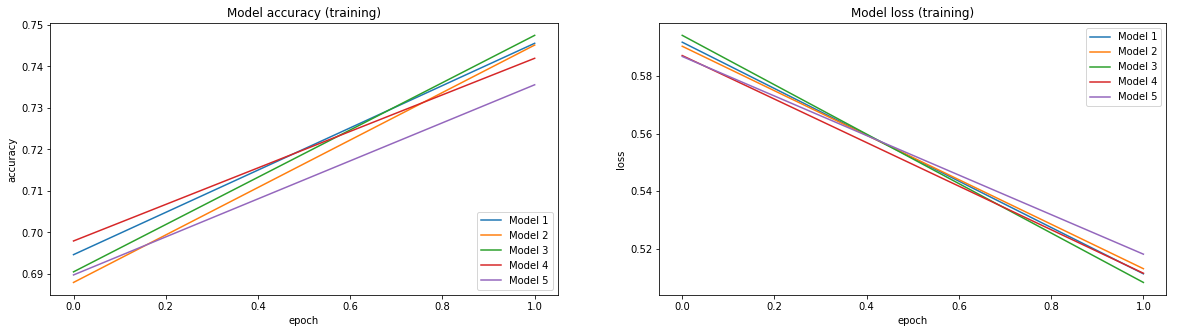

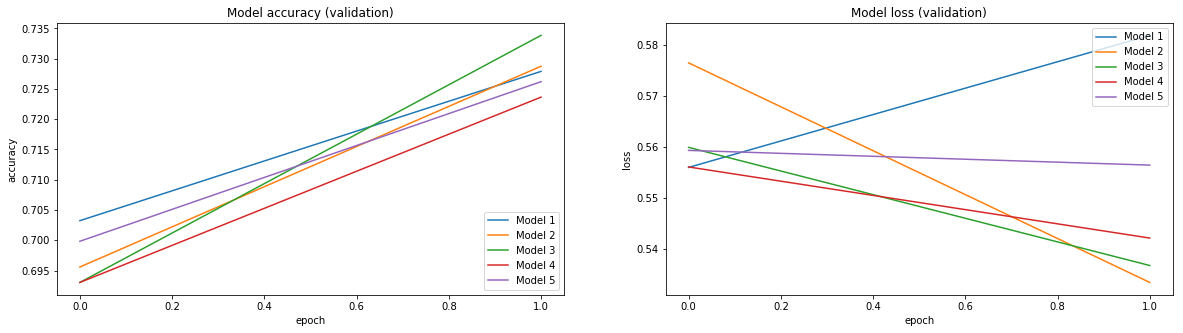

In [40]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

KeyError: 'val_f1micro'

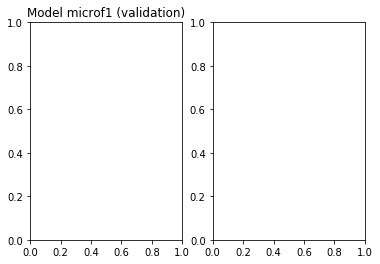

In [37]:
plot_f1('validation', histories, 'val_f1micros', 'val_f1macros')

Final test